In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


from datetime import datetime, timedelta
from seaborn import set_style
set_style("whitegrid")

# Data: Import, Preprocessing, and New Features 

In [18]:
#Import the file
SP_df_raw = pd.read_csv("..\data\sp500.csv")

# Reversing the order of rows
SP_df = SP_df_raw.iloc[::-1]
SP_df = SP_df.reset_index(drop=True)

# Deleting zero rows indicating market/bank holidays
SP_df = SP_df[(SP_df['High']!=0)]
SP_df = SP_df.reset_index(drop=True)

# Change the date to actual date format
SP_df['Date'] = pd.to_datetime(SP_df['Date'])

# Rename the Close/Last column to Close
SP_df.rename(columns = {'Close/Last': 'Close'}, inplace = True)

## Define new variables

# This tracks the daily difference between High and Low
SP_df['HLDiff'] = SP_df['High'] - SP_df['Low']

# This tracks the daily difference between Closing and Opening Data
SP_df['DayDiff'] = SP_df['Close'] - SP_df['Open']

# This tracks the difference between Opening Data of a Day and Closing Data of the Previous Day
SP_df['OvernightDiff'] = SP_df['Open'] - SP_df['Close'].shift(1)

# Move or Binary Move tells us whether from Day n, Close goes up ( = 1) or down (=0)
SP_df['Change'] = np.where(SP_df['Close'].shift(-1) - SP_df['Close'] > 0, 1, 0)
SP_df['Move'] = np.where(SP_df['Close'].shift(-1) - SP_df['Close'] > 0, 1, 0)

# Lag-i is the the price from i days ago 
SP_df['Lag-1'] = SP_df['Close'].shift(1)
SP_df['Lag-2'] = SP_df['Close'].shift(2)
SP_df['Lag-3'] = SP_df['Close'].shift(3)
SP_df['Lag-4'] = SP_df['Close'].shift(4)
SP_df['Lag-5'] = SP_df['Close'].shift(5)
SP_df['Lag-6'] = SP_df['Close'].shift(6)
SP_df['Lag-7'] = SP_df['Close'].shift(7)

# RolAvgi is the the rolling average over the last i days
SP_df['RolAvg7'] = SP_df[['Lag-1','Lag-2','Lag-3', 'Lag-4', 'Lag-5', 'Lag-6', 'Lag-7']].mean(axis=1)
SP_df['RolAvg5'] = SP_df[['Lag-1','Lag-2','Lag-3', 'Lag-4', 'Lag-5']].mean(axis=1)

In [19]:
SP_df

,Date,Close,Open,High,Low,HLDiff,DayDiff,OvernightDiff,Change,Move,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,RolAvg7,RolAvg5
0,2013-10-28,1762.11,1759.42,1764.99,1757.67,7.32,2.69,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-29,1771.95,1762.93,1772.09,1762.93,9.16,9.02,0.82,0,0,1762.11,NaN,NaN,NaN,NaN,NaN,NaN,1762.110000,1762.1100
2,2013-10-30,1763.31,1772.27,1775.22,1757.24,17.98,-8.96,0.32,0,0,1771.95,1762.11,NaN,NaN,NaN,NaN,NaN,1767.030000,1767.0300
3,2013-10-31,1756.54,1763.24,1768.53,1755.72,12.81,-6.70,-0.07,1,1,1763.31,1771.95,1762.11,NaN,NaN,NaN,NaN,1765.790000,1765.7900
4,2013-11-01,1761.64,1758.70,1765.67,1752.70,12.97,2.94,2.16,1,1,1756.54,1763.31,1771.95,1762.11,NaN,NaN,NaN,1763.477500,1763.4775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2023-10-23,4217.04,4210.40,4255.84,4189.22,66.62,6.64,-13.76,1,1,4224.16,4278.00,4314.60,4373.20,4373.63,4327.78,4349.61,4320.140000,4312.7180
2514,2023-10-24,4247.68,4235.79,4259.38,4219.43,39.95,11.89,18.75,0,0,4217.04,4224.16,4278.00,4314.60,4373.20,4373.63,4327.78,4301.201429,4281.4000
2515,2023-10-25,4186.77,4232.42,4232.42,4181.42,51.00,-45.65,-15.26,0,0,4247.68,4217.04,4224.16,4278.00,4314.60,4373.20,4373.63,4289.758571,4256.2960
2516,2023-10-26,4137.23,4175.99,4183.60,4127.90,55.70,-38.76,-10.78,0,0,4186.77,4247.68,4217.04,4224.16,4278.00,4314.60,4373.20,4263.064286,4230.7300


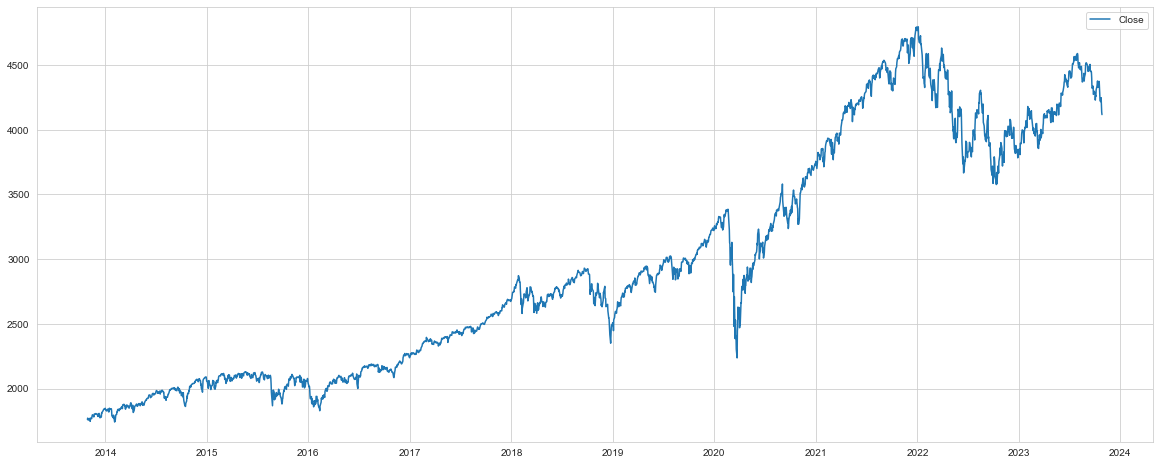

In [4]:
plt.figure(figsize=(20,8))


plt.plot(SP_df['Date'], SP_df['Close'], label = "Close")
plt.legend()

# Gradient Boosting for Regression

In [5]:
# starting_index is used to crop out the first few (oldes) data points
starting_index = 5
X = SP_df[['Lag-1', 'Lag-2','Lag-3']].iloc[starting_index:]
y1 = SP_df['Close'].iloc[starting_index:]
SP_date = SP_df['Date']


#X = SP_df[['Open', 'High', 'Low']].iloc[starting_index:]
#X = SP_df[['Open', 'OvernightDiff']].iloc[starting_index:]
#X = SP_df[['Open']].iloc[starting_index:]
#X = SP_df[['Lag-1', 'Lag-2', 'Lag-3', 'Lag-4', 'Lag-5', 'Lag-6', 'Lag-7']].iloc[starting_index:]
#X = SP_df[['RolAvg5']].iloc[starting_index:]

In [6]:
y1

5       1767.93
6       1762.97
7       1770.49
8       1747.15
9       1770.61
         ...   
2513    4217.04
2514    4247.68
2515    4186.77
2516    4137.23
2517    4117.37
Name: Close, Length: 2513, dtype: float64

Root Mean Squared Error (RMSE): 31.344425293469968


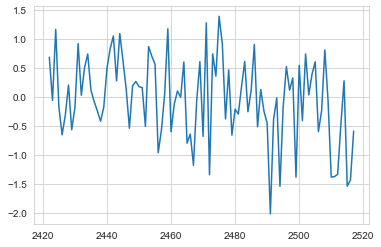

In [7]:
# Use TimeSeriesSplit for time-based splitting
tscv = TimeSeriesSplit(n_splits=25)  # Adjust the number of splits as needed

for train_index, test_index in tscv.split(X):
    X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
    y_train1, y_test1 = y1.iloc[train_index], y1.iloc[test_index]


# Initialize the Gradient Boosting Regressor
gb_model1 = GradientBoostingRegressor(n_estimators=120, learning_rate=0.07)

# Train the model
gb_model1.fit(X_train1, y_train1)

# Make predictions on the test set
y1_pred = gb_model1.predict(X_test1)

# Evaluate the model
pred_error_vector = y_test1 - y1_pred
pred_error_percentage = (y_test1 - y1_pred)*100/y_test1
mse = mean_squared_error(y_test1, y1_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

plt.plot(pred_error_percentage)

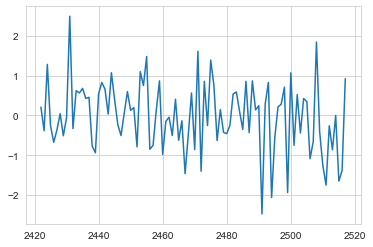

In [8]:
# Use TimeSeriesSplit for time-based splitting
tscv = TimeSeriesSplit(n_splits=25)  # Adjust the number of splits as needed

gb_tune_results = []

for train_index, test_index in tscv.split(X):
    X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
    y_train1, y_test1 = y1.iloc[train_index], y1.iloc[test_index]

for rate in np.linspace(0.01,0.2,20):
    for num_learners in np.linspace(50, 200, 16):
        # Initialize the Gradient Boosting Regressor
        gb_model1 = GradientBoostingRegressor(n_estimators=int(num_learners), learning_rate=rate)

        # Train the model
        gb_model1.fit(X_train1, y_train1)

        # Make predictions on the test set
        y1_pred = gb_model1.predict(X_test1)

        # Evaluate the model
        pred_error_vector = y_test1 - y1_pred
        pred_error_percentage = (y_test1 - y1_pred)*100/y_test1
        mse = mean_squared_error(y_test1, y1_pred)
        rmse = np.sqrt(mse)
        meanpercentage = np.mean(np.abs(pred_error_percentage))
        
        gb_tune_results.append([num_learners, rate, rmse, np.max(np.abs(pred_error_percentage)), meanpercentage])
        #print(f"Root Mean Squared Error (RMSE): {rmse}")

plt.plot(pred_error_percentage)

In [9]:
array = np.array(gb_tune_results)

min_rmse_row = min(array, key=lambda x: x[2])  # x[2] corresponds to the third column (index 2)
min_ep_row = min(array, key=lambda x: x[3])  # x[3] corresponds to the fourth column (index 3)
min_meanep_row = min(array, key=lambda x: x[4])  # x[4] corresponds to the fifth column (index 4)
print("The minimum value of RMSE:", np.round(min_rmse_row,4)[2], "for num_learners = ", min_rmse_row[0], " and learning rate of ", min_rmse_row[1])
print("The minimum value of Max AEP:", np.round(min_ep_row,4)[3], "for num_learners = ", min_ep_row[0], " and learning rate of ", min_ep_row[1])
print("The minimum value of Mean AEP:", np.round(min_meanep_row,4)[4], "for num_learners = ", min_meanep_row[0], " and learning rate of ", min_meanep_row[1])

The minimum value of RMSE: 31.3444 for num_learners =  120.0  and learning rate of  0.06999999999999999
The minimum value of Max AEP: 1.6718 for num_learners =  50.0  and learning rate of  0.09
The minimum value of Mean AEP: 0.5681 for num_learners =  130.0  and learning rate of  0.06999999999999999


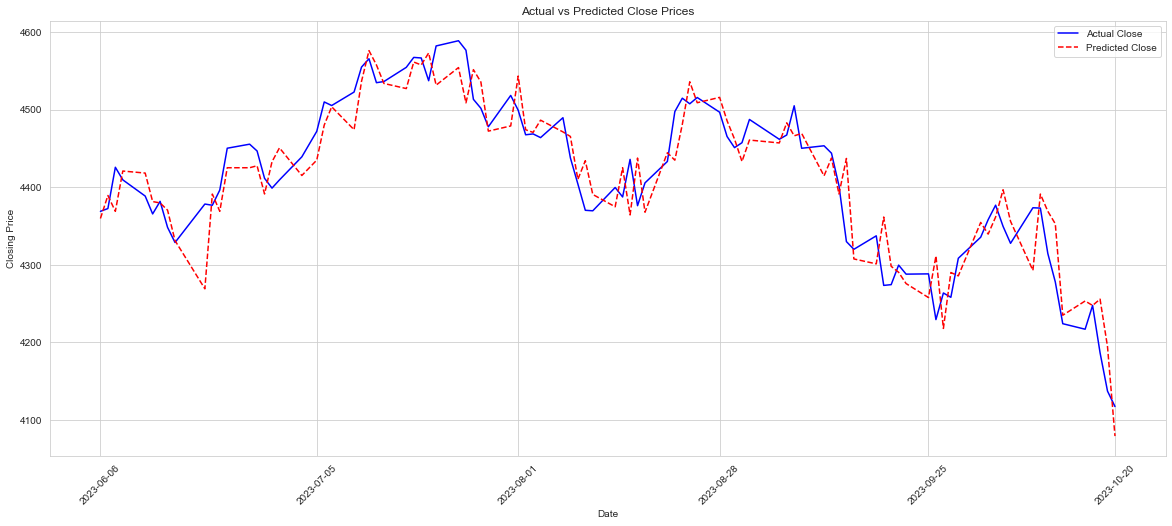

In [10]:
plt.figure(figsize=(20, 8))

# Plot actual Close values
plt.plot(SP_df['Date'].iloc[test_index], y_test1, label='Actual Close', color='blue')

# Plot predicted Close values
plt.plot(SP_df['Date'].iloc[test_index], y1_pred, label='Predicted Close', color='red', linestyle='dashed')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Close Prices')
plt.xticks(SP_df['Date'].iloc[test_index].iloc[[0,19, 38,57,76,95]])
plt.xticks(fontsize = 10, rotation =45)
plt.legend()

# Show the plot
plt.show()


In [11]:
data = pred_error_percentage

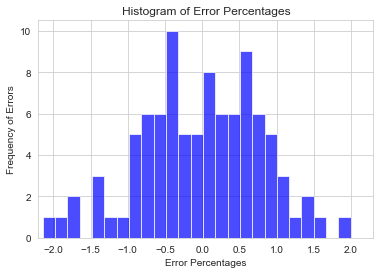

In [12]:
# Creating a histogram
plt.hist(data, bins=30, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.title('Histogram of Error Percentages')
plt.xlabel('Error Percentages')
plt.ylabel('Frequency of Errors')
plt.xlim([-2.2,2.3])
plt.grid(True)
plt.show()
